# Dalitz plot notebook
In the notebook I demonstrate how to
 - define julia funtions
 - plot 1d of 2d functions uning library MathPlotLib to plot 
 - create a dalitz plot in Cartesian coordinated and in the Triangle coordinates

### Plotting functions

In [1]:
using PyPlot
using PyCall
@pyimport numpy.ma as ma

# simple flat plot
function Plot(f, x)
    fx=[f(xi) for xi in x]
    plot(x, fx)
end

# plot of function of 2 variables, 3D plot
function Plot(f, x, y)
    fx=[[xi, yi, f(xi,yi)] for xi in x for yi in y]
    surf([fxi[1] for fxi in fx], [fxi[2] for fxi in fx], [fxi[3] for fxi in fx])
end

# plot of function of 2 variables, color-codded
function DensityPlot(f, x, y)
    xy = [[xi, yi] for xi in x, yi in y]
    zv = [f((xy[i,j][1]+xy[i+1,j+1][1])/2.,
            (xy[i,j][2]+xy[i+1,j+1][2])/2.) for i in 1:(size(xy,1)-1), j in 1:(size(xy,2)-1)]
    zvmask = pycall(ma.array, Any, zv, mask=isnan.(zv))
    xv = [xy[i,j][1] for i in 1:size(xy,1), j in 1:size(xy,2)]
    yv = [xy[i,j][2] for i in 1:size(xy,1), j in 1:size(xy,2)]
    pcolor(xv, yv, zvmask)
end

DensityPlot (generic function with 1 method)

### Kinematics functions

In [2]:
# K\"allen function
λ(x,y,z)=x^2+y^2+z^2-2*x*y-2*y*z-2*z*x

# Break-up momentum
psq(x,y,z)=λ(x,y,z)/(4*x);

# scattering angle in the s-channel
cosθsq(s,t,Msq,m1sq,m2sq,m3sq)=(2s*(t-m2sq-m3sq)-(s+m2sq-m1sq)*(Msq-s-m3sq))^2/(λ(s,m2sq,m3sq)*λ(Msq,s,m1sq))

# inverse to previous one
function t(s,cosθ,Msq,m1sq,m2sq,m3sq)
    e2 = (s+m2sq-m1sq)/(2*sqrt(s))
    e3 = (Msq-s-m3sq)/(2*sqrt(s))
    p2 = sqrt(λ(s,m1sq,m2sq)/(4*s))
    p3 = sqrt(λ(Msq,s,m3sq)/(4*s))
    m2sq+m3sq+2*e2*e3-2*p2*p3*cosθ
end

# border function returns 0 or 1 whether the dacay is forbidden or allowed
function border(s,t,Msq,m1sq,m2sq,m3sq)
    val = 0.0
    √s =sqrt(s); √t =sqrt(t)
    m1 = sqrt(m1sq); m2 = sqrt(m2sq); m3 = sqrt(m3sq)
    Mtot = sqrt(Msq)
    if (√s > m1+m2) && (√s < Mtot-m3) && (√t > m2+m3) && (√t < Mtot-m1) && (cosθsq(s,t,Msq,m1sq,m2sq,m3sq) < 1.)
        val = 1
    end
    return val
end

# BW function
BreitWigner(s,M,Γ) = 1./(M^2-s-1im*M*Γ);

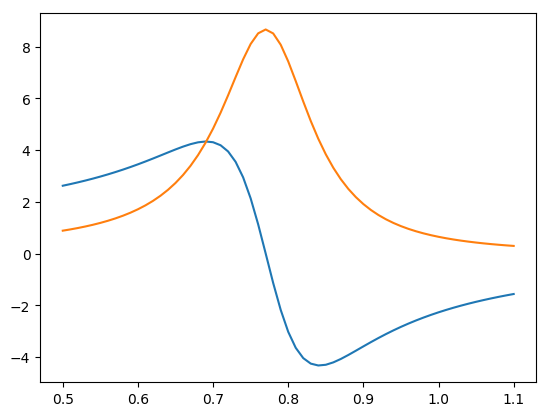

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f2ed01141d0>

In [3]:
Plot(e->real(BreitWigner(e^2,0.77,0.15)), 0.5:0.01:1.1)
Plot(e->imag(BreitWigner(e^2,0.77,0.15)), 0.5:0.01:1.1)

## A few examples
Below we consider examples of the Dalitz Plots to demonstrate various ways to call the plotting functions
* Define a function for matrx element square and plot it.
* Use explicit [`Anonymous Functions`](https://docs.julialang.org/en/release-0.4/manual/functions/#anonymous-functions) function.
* Use form [`Do-Block Syntax`](https://docs.julialang.org/en/release-0.4/manual/functions/#do-block-syntax-for-function-arguments) for the anonymous function.

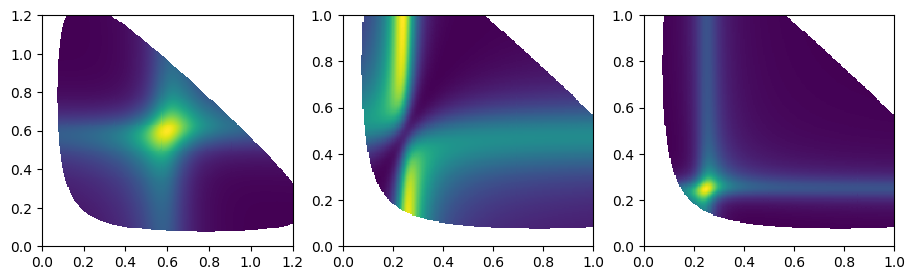

PyObject <matplotlib.collections.PolyCollection object at 0x7f2ead8be790>

In [4]:
fig = figure(figsize=(11, 3));

#--------------------------------------------------------------------
# add the first pad
fig[:add_subplot](131);  # devision 1x3, focus at the pad 1

# Function for the square of the matrix element
mπ=0.139;
mρ=0.7755; Γρ=0.15; Ma1 = 1.26;
Matr(s,t) = 1./(mρ^2-s-1im*Γρ*mρ) + 1./(mρ^2-t-1im*Γρ*mρ)
function MatrSq(s,t)
    if (border(s,t,Ma1^2,mπ^2,mπ^2,mπ^2) == 0)
        return NaN
    end
    abs(Matr(s,t))^2
end
# plot
DensityPlot(MatrSq, 0:0.005:1.2, 0:0.005:1.2)

#--------------------------------------------------------------------
# add the second pad
fig[:add_subplot](132);  # devision 1x3, focus at the pad 2

# Do-Block Syntax
DensityPlot(0:0.005:1, 0:0.005:1) do s,t
    # border of Dalitz plot
    if (border(s,t,Ma1^2,mπ^2,mπ^2,mπ^2) == 0)
        return NaN
    end
    # matrix element
    mR1=0.5; mR2=0.7; ΓR1=0.1; ΓR2=0.2;
    c1=1.; c2=-1.9;
    Mat = c1/(mR1^2-s-1im*ΓR1*mR1) + c2/(mR2^2-t-1im*ΓR2*mR2)
    # return is square of matrix elemtn
    return abs(Mat)^2
end

#--------------------------------------------------------------------
# add the third pad
fig[:add_subplot](133);  # devision 1x3, focus at the pad 3

# explisit anonymous function
mR=0.5; ΓR=0.1
# plot
DensityPlot((s,t)->begin
    if (border(s,t,Ma1^2,mπ^2,mπ^2,mπ^2) == 0)
        return NaN
    end
    mat=1./(mR^2-s-1im*ΓR*mR) + 1./(mR^2-t-1im*ΓR*mR)
    abs(mat)^2
end, 0:0.005:1, 0:0.005:1)

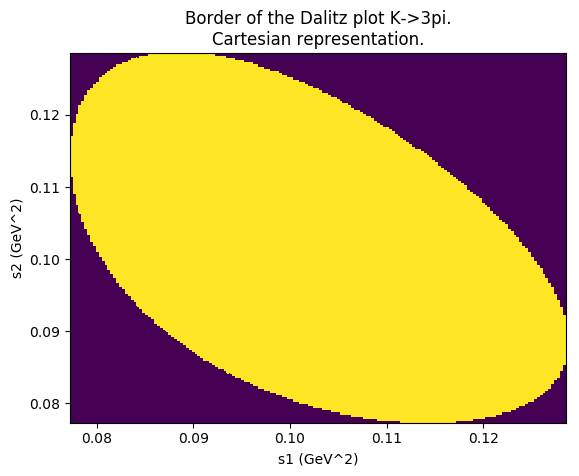

3-element Array{Any,1}:
 PyObject <matplotlib.text.Text object at 0x7f2eaca18390>
 PyObject <matplotlib.text.Text object at 0x7f2eacae8a50>
 PyObject <matplotlib.text.Text object at 0x7f2eac9c52d0>

In [5]:
# set the variables
mk=0.498;
mπ=0.139;

# plot the border function K → 3π
coll = DensityPlot((s,t)->border(s,t,mk^2,mπ^2,mπ^2,mπ^2), 4mπ^2:0.0003:(mk-mπ)^2, 4mπ^2:0.0003:(mk-mπ)^2)
coll[:axes][:set](title="Border of the Dalitz plot K->3pi.\nCartesian representation.",
                xlabel="s1 (GeV^2)", ylabel="s2 (GeV^2)")

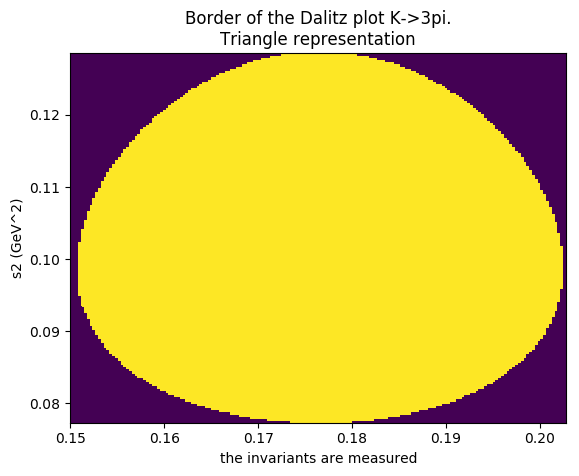

3-element Array{Any,1}:
 PyObject <matplotlib.text.Text object at 0x7f2eabac1d10>
 PyObject <matplotlib.text.Text object at 0x7f2eabaf9f50>
 PyObject <matplotlib.text.Text object at 0x7f2eaba7a150>

In [6]:
# plot the border function K → 3π
mπ=0.139;
coll = DensityPlot((x,y)->border((sqrt(3.)x-y)/2., y, mk^2,mπ^2,mπ^2,mπ^2), 0.15:0.0003:0.203, 4mπ^2:0.0003:(mk-mπ)^2)
coll[:axes][:set](title="Border of the Dalitz plot K->3pi.\nTriangle representation",
                xlabel="the invariants are measured", ylabel="s2 (GeV^2)")

## Particles with spin
In the example below a particle withe the spin $1$ decays to the pseudoscalars.
Two resonances with the spin 1 are present.
\begin{equation}
\mathcal{M} =
\overbrace{h_1(|\vec{p_1}|)}^{\text{first decay}}\,
\underbrace{h_1(|\vec{q_1}|)}_{\text{second decay}}\,
\sin{\theta_{23}}\,
\frac{c_1}{m_1^2-s_1-i m_1 \Gamma_1} + 
\overbrace{h_1(|\vec{p_3}|)}^{\text{first decay}}\,
\underbrace{h_1(|\vec{q_3}|)}_{\text{second decay}}\,
\sin{\theta_{12}}\,
\frac{c_3}{m_3^2-s_3-i m_3 \Gamma_3}
\end{equation}

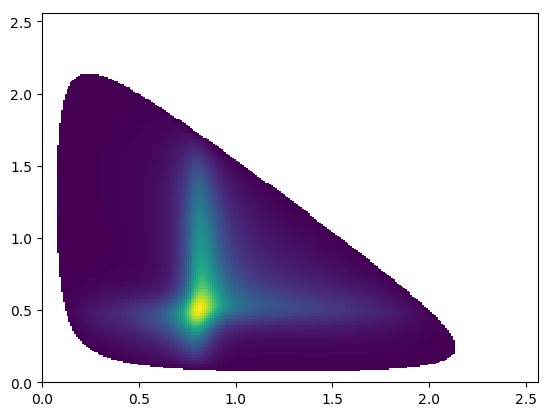

PyObject <matplotlib.collections.PolyCollection object at 0x7f2ea6ac9b10>

In [7]:
M = 1.6; m = 0.139;
DensityPlot(0:0.01:M^2, 0:0.01:M^2) do s,t
    # border of Dalitz plot
    bord = border(s,t,M^2,m^2,m^2,m^2)
    if (bord == 0)
        return NaN;
    end
    # Matrix element
    Mat = 0.0
    
    # ------ the first resonance in the s-channel --------
    mR1=0.9; ΓR1=0.1; c1=1.;
    cosθs = sqrt(cosθsq(s, t, M^2, m^2, m^2, m^2))
    sinθs = sqrt(1-cosθs*cosθs)
    R = 5.  # GeV^{-2}
    psq1s = psq(s,m^2,m^2); psq2s = psq(s,M^2,m^2);
    # p*q*sin(theta_t)/Propogator
    nums = sqrt(R^2*psq1s / (1+R^2*psq1s) * R^2*psq2s / (1+R^2*psq2s)) * sinθs
    Mat += c1*sinθs/(mR1^2-s-1im*ΓR1*mR1)
    
    # ------ the second resonance in the t-channel --------
    mR3=0.7; ΓR3=0.2; c3=1.2;
    u = M^2+3*m^2-s-t
    cosθt = sqrt(cosθsq(t, u, M^2, m^2, m^2, m^2))
    sinθt = sqrt(1-cosθt*cosθt)
    psq1t = psq(t,m^2,m^2); psq2t = psq(t,M^2,m^2);
    # p*q*sin(theta_t)/Propogator
    numt = sqrt(R^2*psq1t / (1+R^2*psq1t) * R^2*psq2t / (1+R^2*psq2t)) * sinθt
    Mat += c3*numt/(mR3^2-t-1im*ΓR3*mR3)
    # return is square of matrix element
    return abs(Mat)^2
end